# 5 - Data integration & analysis
This notebook is used to integrate and analyze the geospatial, remote sensing and meteorological time series datasets.

## Setup

In [1]:
# Import libraries
import os
import datetime
from math import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopandas import GeoDataFrame
import contextily as cx

In [2]:
# Set working directory
os.chdir(os.path.join('E:/',
                      'McKinley'))

# Directory to store downloaded Landsat 8 data
figure_dir = os.path.join('figures')

# Check if directory exists
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## Restore datasets

In [3]:
# Filtered seeding unit datasets
%store -r mckinley_seeding_subset_PARlo
#%store -r mckinley_seeding_subset

# Original Landsat 8 time series
%store -r landsat_8_time_series_interpol
landsat_8_time_series_interpol = landsat_8_time_series_interpol.reset_index()

# Smoothed Landsat 8 time series
%store -r landsat_8_time_series_rlmean
landsat_8_time_series_rlmean = landsat_8_time_series_rlmean.reset_index()
landsat_8_time_series_rlmean['date'] = pd.to_datetime(landsat_8_time_series_rlmean['date'])

# Met data
%store -r met_data_mckinley_df

## Calculate NDVI annual metrics for each seeding unit

In [4]:
# Temporary list to store results
su_ndvi_annual_change = []

# Loop over each seeding unit
for i, row in mckinley_seeding_subset_PARlo.iterrows():

    # Format date from seeding unit data
    su_date = datetime.datetime.strptime(
        (str(row.Start_Year) + '-01-01'), "%Y-%m-%d")

    # Subset the time series dataframe to the current seeding unit and clip to its time extent
    su_rs_time_series = landsat_8_time_series_rlmean[(
        landsat_8_time_series_rlmean.SuId == i) & (landsat_8_time_series_rlmean.date >= su_date)]

    # Intervention year
    intervention_year = 0

    # Group seeding unit time series by year and calculate metrics for each year
    for year in su_rs_time_series.groupby(su_rs_time_series.date.dt.year):

        # Calculate annual change in NDVI for smoothed data by subtracting
        # the final NDVI value for the year from the first
        ndvi_annual_change = float(year[1].MeanNdvi.tail(
            1)) - float(year[1].MeanNdvi.head(1))

        # Calculate the mean NDVI for the smoothed data
        ndvi_annual_mean = year[1].MeanNdvi.mean()

        # Calculate the NDVI anomaly for the smoothed data; change in NDVI from intervention year 0
        # Assign the year 0 value
        if intervention_year == 0:
            ndvi_baseline = ndvi_annual_mean
        # Calculate the NDVI anomaly
        ndvi_anomaly = (ndvi_annual_mean - ndvi_baseline) / \
            (ndvi_annual_mean + ndvi_baseline)

        # Calculate the max NDVI from the raw NDVI time series
        ndvi_max = landsat_8_time_series_interpol[(landsat_8_time_series_interpol.SuId == i) &
                                                  (landsat_8_time_series_interpol.date.dt.year == year[0])].MeanNdvi.max()

        # Append metrics to a list
        su_ndvi = [i, year[0], intervention_year,
                   ndvi_annual_change, ndvi_annual_mean, ndvi_max, ndvi_anomaly]

        # Append to temporary list
        su_ndvi_annual_change.append(su_ndvi)

        # Iterate the intervention year
        intervention_year += 1

# Convert the list to a df
su_ndvi_annual_change_df = pd.DataFrame(su_ndvi_annual_change,
                                        columns=['SuId', 'Year', 'Intervention_Year',
                                                 'NDVI_delta', 'NDVI_mean', 'NDVI_max', 'NDVI_anomaly'])
# landsat_8_ts_reformatted.set_index('SuId')

# Remove incomplete values from 2021 as we are dealing with annual data
drop = su_ndvi_annual_change_df[su_ndvi_annual_change_df['Year'] == 2021].index
su_ndvi_annual_change_df.drop(drop, inplace=True)

su_ndvi_annual_change_df

,SuId,Year,Intervention_Year,NDVI_delta,NDVI_mean,NDVI_max,NDVI_anomaly
0,172,2017,0,0.003429,0.102241,0.141530,0.000000
1,172,2018,1,0.014250,0.111236,0.139096,0.042138
2,172,2019,2,0.027377,0.126691,0.255584,0.106803
3,172,2020,3,0.027374,0.161916,0.227001,0.225908
5,816,2013,0,-0.007931,0.167476,0.221923,0.000000
...,...,...,...,...,...,...,...
211,2646,2020,1,0.005811,0.164134,0.218244,-0.016286
213,2648,2019,0,-0.010371,0.158362,0.223770,0.000000
214,2648,2020,1,0.013277,0.156260,0.216266,-0.006679
216,2650,2019,0,-0.010438,0.156453,0.239530,0.000000


## Resample meterological data to yearly data

In [5]:
# Resample met data to yearly values
met_data_mckinley_df_annual = met_data_mckinley_df.resample('Y').sum()

# Add column for year
met_data_mckinley_df_annual['Year']=pd.DatetimeIndex(met_data_mckinley_df_annual.index).year

# Remove incomplete values from 2021
drop = met_data_mckinley_df_annual[met_data_mckinley_df_annual['Year'] == 2021].index
met_data_mckinley_df_annual.drop(drop, inplace=True)
met_data_mckinley_df_annual

,pr,eto,Year
datetime,,,
2013-12-31,294.029337,1368.014815,2013
2014-12-31,211.298197,1464.717591,2014
2015-12-31,342.777599,1356.438671,2015
2016-12-31,274.456320,1436.707471,2016
2017-12-31,246.700000,1507.600001,2017
2018-12-31,233.299999,1548.700000,2018
2019-12-31,283.499999,1417.999998,2019
2020-12-31,192.700000,1583.600001,2020


## Add meteorological variables to seeding unit df

In [6]:
# Join the NDVI time series and met dataframes
su_ndvi_annual_change_df = pd.merge(su_ndvi_annual_change_df, met_data_mckinley_df_annual, how='inner', on = 'Year')

# Rename columns
su_ndvi_annual_change_df.rename(columns={"pr": 'precip'}, inplace=True)
su_ndvi_annual_change_df

,SuId,Year,Intervention_Year,NDVI_delta,NDVI_mean,NDVI_max,NDVI_anomaly,precip,eto
0,172,2017,0,0.003429,0.102241,0.141530,0.000000,246.70000,1507.600001
1,816,2017,4,0.001221,0.216271,0.321780,0.127155,246.70000,1507.600001
2,913,2017,4,-0.006413,0.174824,0.231882,-0.021546,246.70000,1507.600001
3,916,2017,4,-0.010598,0.188461,0.264178,0.114823,246.70000,1507.600001
4,1265,2017,4,-0.015763,0.201751,0.278407,0.073496,246.70000,1507.600001
...,...,...,...,...,...,...,...,...,...
172,1594,2016,2,0.028511,0.200669,0.269095,0.142008,274.45632,1436.707471
173,1601,2016,2,0.004802,0.161960,0.172106,-0.022915,274.45632,1436.707471
174,1608,2016,2,0.004015,0.185511,0.188995,0.042903,274.45632,1436.707471
175,1655,2016,2,0.007668,0.151918,0.165540,-0.004157,274.45632,1436.707471


## Join time series data with seeding unit data
Add some of the seeding unit data such as seeding type back to the remote sensing and meteorological time series

In [7]:
su_ndvi_annual_change_df = pd.merge(
    su_ndvi_annual_change_df, mckinley_seeding_subset_PARlo,
    how='inner', left_on='SuId', right_index=True)
su_ndvi_annual_change_df

,SuId,Year,Intervention_Year,NDVI_delta,NDVI_mean,NDVI_max,NDVI_anomaly,precip,eto,Mine_Area,Start_Year,End_Year,GIS_Acre2,Agreement,Seed_Type,TYPE,geometry,PAR
0,172,2017,0,0.003429,0.102241,0.141530,0.000000,246.700000,1507.600001,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
18,172,2018,1,0.014250,0.111236,0.139096,0.042138,233.299999,1548.700000,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
43,172,2019,2,0.027377,0.126691,0.255584,0.106803,283.499999,1417.999998,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
85,172,2020,3,0.027374,0.161916,0.227001,0.225908,192.700000,1583.600001,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
1,816,2017,4,0.001221,0.216271,0.321780,0.127155,246.700000,1507.600001,None,2013,2013,55.702517,Permanent Program,Seed,Seeding,"POLYGON ((2378986.229 1702322.589, 2378982.791...",0.008140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2646,2020,1,0.005811,0.164134,0.218244,-0.016286,192.700000,1583.600001,None,2019,2019,4.830405,Permanent Program,Reseed,Reseeding,"POLYGON ((2398238.925 1700967.351, 2398244.226...",0.009492
83,2648,2019,0,-0.010371,0.158362,0.223770,0.000000,283.499999,1417.999998,None,2019,2019,7.350496,Permanent Program,Interseed,Interseeding,"POLYGON ((2397437.054 1703154.667, 2397439.018...",0.008919
125,2648,2020,1,0.013277,0.156260,0.216266,-0.006679,192.700000,1583.600001,None,2019,2019,7.350496,Permanent Program,Interseed,Interseeding,"POLYGON ((2397437.054 1703154.667, 2397439.018...",0.008919
84,2650,2019,0,-0.010438,0.156453,0.239530,0.000000,283.499999,1417.999998,None,2019,2019,49.372159,Permanent Program,Interseed,Interseeding,"POLYGON ((2398828.096 1700499.711, 2398861.829...",0.004498


## Classify and map seeding units using NDVI anomaly

C:\Users\ekqo\Miniconda3\envs\earth-analytics-python\lib\site-packages\contextily\tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling
C:\Users\ekqo\Miniconda3\envs\earth-analytics-python\lib\site-packages\contextily\tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling
C:\Users\ekqo\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


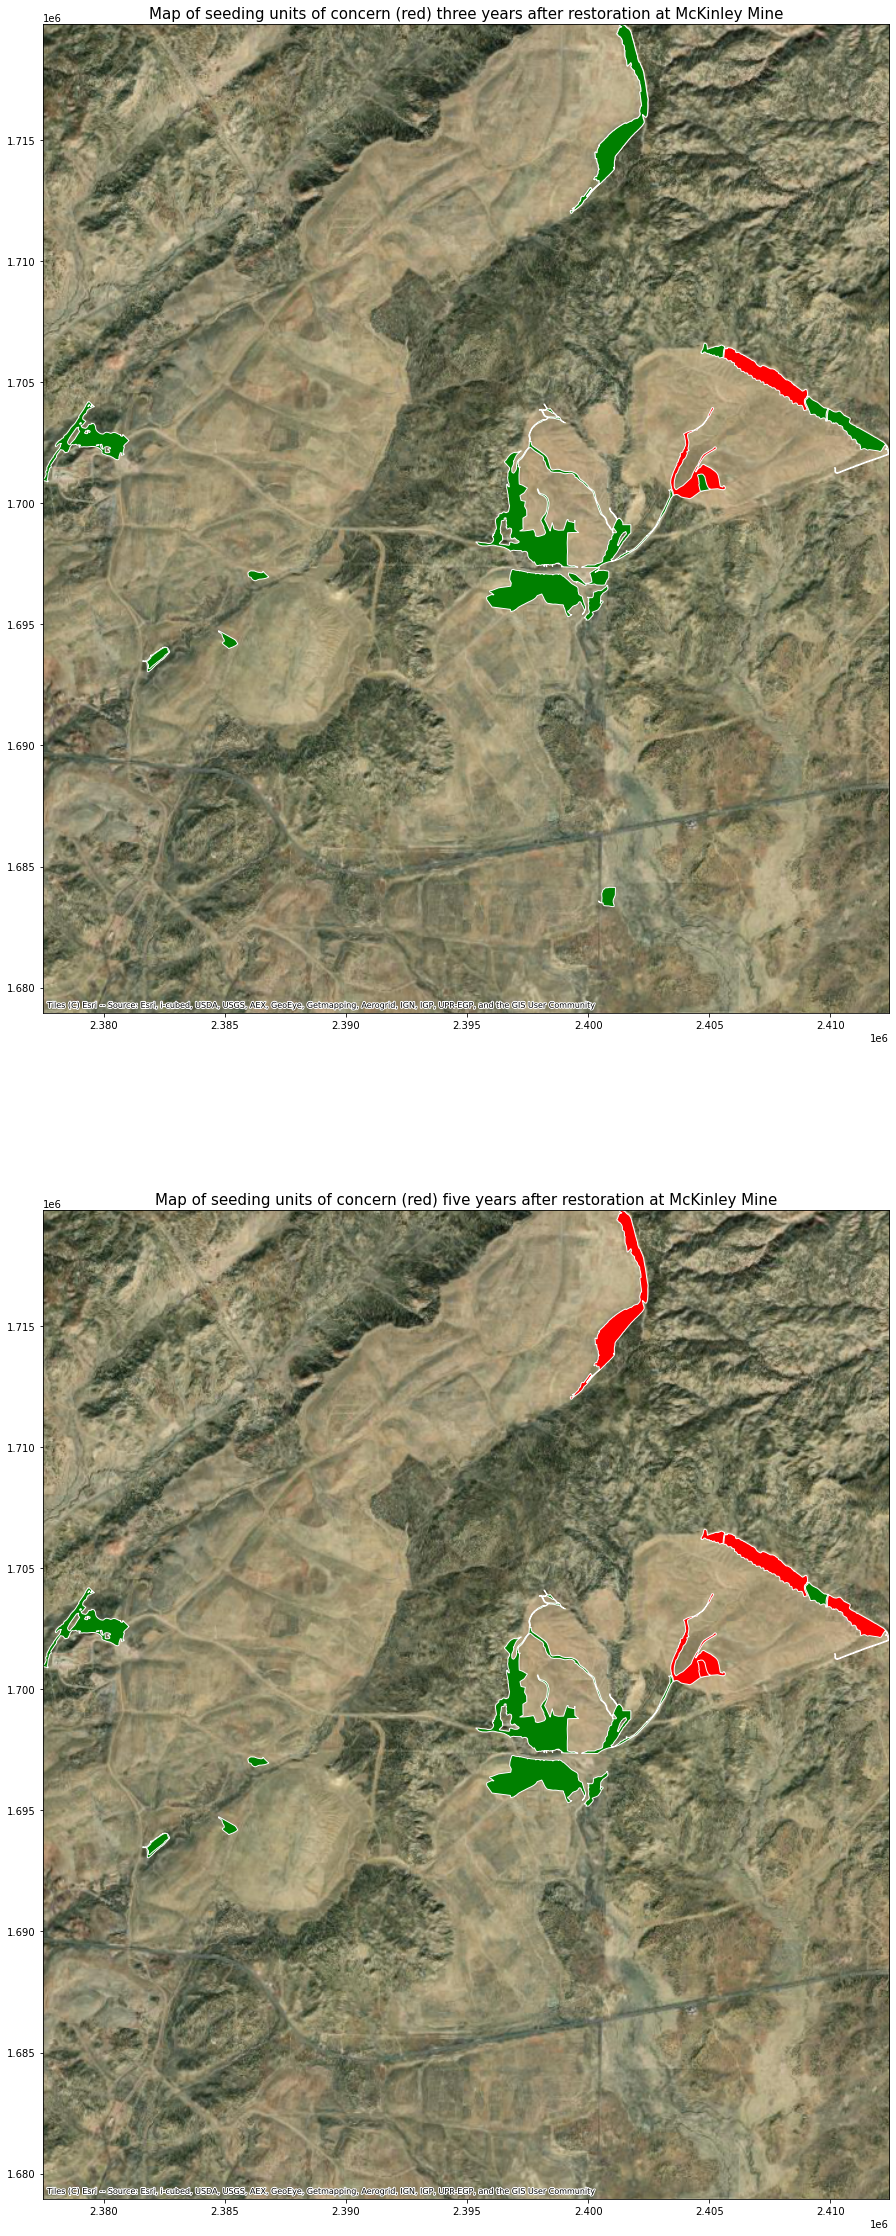

In [19]:
# Convert the df to a gdf
su_ndvi_annual_change_gdf = GeoDataFrame(
    su_ndvi_annual_change_df, geometry=su_ndvi_annual_change_df.geometry)

# Plot the filtered seeding units
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 40))

# Set the bounds
xlim = ([su_ndvi_annual_change_gdf.total_bounds[0],  su_ndvi_annual_change_gdf.total_bounds[2]])
ylim = ([su_ndvi_annual_change_gdf.total_bounds[1],  su_ndvi_annual_change_gdf.total_bounds[3]])

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

# Plot the su of concern
su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 3) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] <= 0)].plot(ax=ax1, color='Red', edgecolor='white', linewidth=1)

su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 3) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] >= 0)].plot(ax=ax1, color='Green', edgecolor='white', linewidth=1)

cx.add_basemap(ax1, crs=mckinley_seeding_subset_PARlo.crs.to_string(),
               source=cx.providers.Esri.WorldImagery)

ax1.set_title(
    "Map of seeding units of concern (red) three years after restoration at McKinley Mine", fontsize=15)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

# Plot the su of concern
su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 5) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] <= 0)].plot(ax=ax2, color='Red', edgecolor='white', linewidth=1)

su_ndvi_annual_change_gdf[(su_ndvi_annual_change_gdf['Intervention_Year'] == 5) & (
    su_ndvi_annual_change_gdf['NDVI_anomaly'] >= 0)].plot(ax=ax2, color='Green', edgecolor='white', linewidth=1)

cx.add_basemap(ax2, crs=mckinley_seeding_subset_PARlo.crs.to_string(),
               source=cx.providers.Esri.WorldImagery)

ax2.set_title(
    "Map of seeding units of concern (red) five years after restoration at McKinley Mine", fontsize=15)

fig.show()

In [9]:
su_ndvi_annual_change_gdf

,SuId,Year,Intervention_Year,NDVI_delta,NDVI_mean,NDVI_max,NDVI_anomaly,precip,eto,Mine_Area,Start_Year,End_Year,GIS_Acre2,Agreement,Seed_Type,TYPE,geometry,PAR
0,172,2017,0,0.003429,0.102241,0.141530,0.000000,246.700000,1507.600001,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
18,172,2018,1,0.014250,0.111236,0.139096,0.042138,233.299999,1548.700000,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
43,172,2019,2,0.027377,0.126691,0.255584,0.106803,283.499999,1417.999998,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
85,172,2020,3,0.027374,0.161916,0.227001,0.225908,192.700000,1583.600001,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
1,816,2017,4,0.001221,0.216271,0.321780,0.127155,246.700000,1507.600001,None,2013,2013,55.702517,Permanent Program,Seed,Seeding,"POLYGON ((2378986.229 1702322.589, 2378982.791...",0.008140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2646,2020,1,0.005811,0.164134,0.218244,-0.016286,192.700000,1583.600001,None,2019,2019,4.830405,Permanent Program,Reseed,Reseeding,"POLYGON ((2398238.925 1700967.351, 2398244.226...",0.009492
83,2648,2019,0,-0.010371,0.158362,0.223770,0.000000,283.499999,1417.999998,None,2019,2019,7.350496,Permanent Program,Interseed,Interseeding,"POLYGON ((2397437.054 1703154.667, 2397439.018...",0.008919
125,2648,2020,1,0.013277,0.156260,0.216266,-0.006679,192.700000,1583.600001,None,2019,2019,7.350496,Permanent Program,Interseed,Interseeding,"POLYGON ((2397437.054 1703154.667, 2397439.018...",0.008919
84,2650,2019,0,-0.010438,0.156453,0.239530,0.000000,283.499999,1417.999998,None,2019,2019,49.372159,Permanent Program,Interseed,Interseeding,"POLYGON ((2398828.096 1700499.711, 2398861.829...",0.004498


## Store the outputs

In [10]:
%store su_ndvi_annual_change_df
%store met_data_mckinley_df_annual

Stored 'su_ndvi_annual_change_df' (DataFrame)
Stored 'met_data_mckinley_df_annual' (DataFrame)
